# Term project - MNIST visualization<br>
Deep neural network 구현 및 Visualization과 이를 통한 Neural network에 대한 이해 향상


## MNIST dataset 불러 오기 및 시각화

1. data에 대한 pca(2d라? 겹치는 경유 확인가능) + tsne결과 확인하기
    둘의 차이 확인하기
2. layer들의 dimension 확인

• Input image에 대한 PCA, t-SNE 결과
• hidden vector (a[0], z[1], a[1], z[2], a[2])에 대한 PCA, ,t-SNE결과
    ->  총 10장
• 결과 분석 (자유롭게)


In [1]:
from __future__ import print_function

import torch
from torch import nn
from torch import optim
import numpy as np

import time

# dataset
import torchvision 
from torchvision import datasets
from torchvision import transforms

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# sklearn
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns


%matplotlib inline

## Hyperparameter
modeling 과정에서 직접 설정하는 값입니다.<br>
- batch_size
- learning rate : 학습률(gradient를 통해 weight를 이동, 변화시키는 정도)
- epoch_nums : 학습을 반복하는 횟수
- batch size : 한번의 batch마다 주어지는 data sample의 size (batch: 나누어진 dataset)
- momentum : weight의 update과정에서 관성, 가속도를 주어 감소, 증가하는 방향으로 더 많은 변화를 준다.

In [2]:
batch_size = 12
# batch_size = 32
learning_rate = 0.01
# learning_rate = 0.05
# learning_rate = 0.1
epoch_num = 10
# epoch_num = 20

## MNIST dataset
### torchvision.datasets.MNIST = (root="", train="", dawnload="",trasform ="")
root = "data의 경로" <br>
train = True(학습용 데이터) or False(test용 데이터) <br>
tramsform - 데이터 형태 <br>
download = True(MNIST dataset이 없으면 다운로드한다.) <br>

In [3]:
train_data = datasets.MNIST(root= '..\datasets', train= True, download= True, transform= transforms.ToTensor())
test_data = datasets.MNIST(root= '..\datasets', train= False, download= True, transform= transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

# Deep Neural Network
input layer와 ouput layer사이에 hidden layer를 2개이상 지닌 neural network을 의미합니다.
- 분류와 수치예측을 주목적으로 하여 이미지 학습과 문자인식에 유용하게 사용되고 있는 신경망입니다.

## Using squential 
squential하여 내부  module에 접급하지 않는다.

## Using ModuleList
Module을 리스트 형태로 담을 때 사용합니다. ModuleList에서는 module하나하나에 접근이 가능하다.

In [4]:
# Using ModuleList
class DeepNN_ML(nn.Module):
    def __init__(self):
        super(DeepNN_ML, self).__init__()

        self.in_dim = 28 * 28 # MNIST
        self.out_dim = 10 # 0 ~ 9
        self.az = [ [] for i in range(10)] #a0,z1,a1,z2,a2,z3,a3,z4,z4.z5
        
        self.list = nn.ModuleList([
            nn.Linear(in_features = self.in_dim, out_features = 512),
            nn.ReLU(),
            nn.Linear(in_features = 512, out_features = 256),
            nn.ReLU(),
            nn.Linear(in_features = 256, out_features = 128),
            nn.ReLU(),
            nn.Linear(in_features = 128, out_features = 64),
            nn.ReLU(),
            nn.Linear(in_features = 64, out_features = self.out_dim)
        ])


    def forward(self, x, V):
        fw = x.view(-1, self.in_dim)
        if V > 5000: 
            for i, module in enumerate(self.list):
                fw = module(fw)
        else: # 마지막 epoch에서 a[0].z[1]~z[5]를 self.az에 저장한다
            self.az[0].append(fw.tolist())
            for i, module in enumerate(self.list):
                fw = module(fw)
                self.az[i+1].append(fw.tolist())
        return fw



In [5]:
model_ML = DeepNN_ML()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ML.parameters(), lr = learning_rate)
label_list = []
V = (60000/batch_size) * epoch_num
for epoch in range(epoch_num):
    running_loss = 0.0
    for i, data in enumerate(train_loader,0):
        # get the inputs: data is a list of [input, label]
        inputs, labels = data
        if epoch == epoch_num-1:
            label_list.append(labels.tolist()) # 마지막 epoch에서
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward, backward, optimizer
        outputs = model_ML(inputs, V)
        loss = criterion(outputs, labels) # loss
        loss.backward() # backward
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i+1) % 2000 == 0 : # print every 2000 mini-batch
            print("[%d, %5d] loss: %.3f" % (epoch+1, i+1, running_loss/2000) )
            running_loss = 0.0
        V -= 1
print("Finished training")


[1,  2000] loss: 2.239
[1,  4000] loss: 0.796
[2,  2000] loss: 0.324
[2,  4000] loss: 0.240
[3,  2000] loss: 0.158
[3,  4000] loss: 0.150
[4,  2000] loss: 0.108
[4,  4000] loss: 0.106
[5,  2000] loss: 0.080
[5,  4000] loss: 0.079
[6,  2000] loss: 0.060
[6,  4000] loss: 0.067
[7,  2000] loss: 0.045
[7,  4000] loss: 0.051
[8,  2000] loss: 0.037
[8,  4000] loss: 0.038
[9,  2000] loss: 0.027
[9,  4000] loss: 0.031
[10,  2000] loss: 0.022
[10,  4000] loss: 0.025
Finished training


In [6]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [7]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images, nrow = batch_size))
print('GroundTruth')
print("  "+'  '.join('%3s' % label.item() for label in labels))

outputs = model_ML(images)
_, predicted = torch.max(outputs, 1)
print("Prediction")
print("  "+'  '.join('%3s' % label.item() for label in predicted))

In [ ]:
n_list = ["a0","z1","a1","z2","a2","z3","a3","z4","a4","z5"]

label_list = np.array(label_list).reshape(-1,60000)[0]
print("label",label_list.shape)
for i in range(10):
    model_ML.az[i] = np.array(model_ML.az[i])
    model_ML.az[i] = model_ML.az[i].reshape(60000,-1)
    print(i, n_list[i], model_ML.az[i].shape)

Error: Session cannot generate requests

# PCA vs t-SNE

In [ ]:
class visualization():
    def __init__(self, Y, N):
        self.Y = Y
        self.N = N
        self.pca = PCA(n_components=2)
        self.tsne = TSNE(n_components=2, verbose=1, perplexity = 40, n_iter=300)
        self.df = [[] for i in range(10)]
        self.df_subset = [[] for i in range(10)]

        np.random.seed(42)
        self.rndperm = [[] for i in range(10)]

    def Pca(self,i,fc):
        pca_result = self.pca.fit_transform(self.df_subset[i][fc].values) 
        self.df_subset[i]['pca-one'] = pca_result[:,0]
        self.df_subset[i]['pca-two'] = pca_result[:,1]
        print('Explained variation per principal component:{}'.format(self.pca.explained_variance_ratio_))
    
    def Tsne(self,i,fc):
        time_start = time.time()
        tsne_result = self.tsne.fit_transform(self.df_subset[i][fc].values) 
        self.df_subset[i]['tsne-2d-one'] = tsne_result[:,0]
        self.df_subset[i]['tsne-2d-two'] = tsne_result[:,1]
        print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
    
    def compression(self, X, i):
        feat_cols = [f'pixel{i}' for i in range (X.shape[1])]
        self.df[i] = pd.DataFrame(X, columns = feat_cols)
        self.df[i]["y"] = self.Y

        self.rndperm[i] = np.random.permutation(self.df[i].shape[0])
        self.df_subset[i] = self.df[i].loc[self.rndperm[i][:self.N],:].copy() # make subset

        self.Pca(i,feat_cols)
        self.Tsne(i,feat_cols)

    def draw(self, i, name):
        plt.figure(figsize=(26,9))
        plt.subplot(1,2,1)
        plt.title("PCA:" + name)
        sns.scatterplot(
            x="pca-one", y="pca-two",
            hue="y",
            palette=sns.color_palette("hls",10), # hue(=y)의 가지수
            data= self.df_subset[i],
            alpha=0.3
        )
        plt.subplot(1, 2, 2)
        plt.title("t-SNE:" + name)
        sns.scatterplot(
            x="tsne-2d-one", y="tsne-2d-two",
            hue="y",
            palette=sns.color_palette("hls",10), # hue(=y)의 가지수
            data= self.df_subset[i],
            alpha=0.3
        )
        plt.show()
    

In [ ]:
N = 10000 # subset size
visual = visualization(label_list, N)
for i in range(10):
    visual.compression(model_ML.az[i], i)


Explained variation per principal component:[0.09716133 0.07125305]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.009s...


D:\develop\Anaconda\envs\ai21\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\develop\Anaconda\envs\ai21\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 10000 samples in 2.176s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.123789
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.937538
[t-SNE] KL divergence after 300 iterations: 2.813206
t-SNE done! Time elapsed: 11.572081565856934 seconds
Explained variation per principal component:[0.15534415 0.

D:\develop\Anaconda\envs\ai21\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\develop\Anaconda\envs\ai21\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.006s...
[t-SNE] Computed neighbors for 10000 samples in 1.974s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.179085
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.011597
[t-SNE] KL divergence after 300 iterations: 2.697825
t-SNE done! Time elapsed:

D:\develop\Anaconda\envs\ai21\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\develop\Anaconda\envs\ai21\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.006s...
[t-SNE] Computed neighbors for 10000 samples in 1.975s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.142626
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.437317
[t-SNE] KL divergence after 300 iterations: 2.637471
t-SNE done! Time elapsed:

D:\develop\Anaconda\envs\ai21\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\develop\Anaconda\envs\ai21\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 10000 samples in 1.903s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.728763
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.942886
[t-SNE] KL divergence after 300 iterations: 2.544061
t-SNE done! Time elapsed: 12.676597833633423 seconds
Explained variation per principal component:[0.21779594 0.

D:\develop\Anaconda\envs\ai21\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\develop\Anaconda\envs\ai21\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 10000 samples in 1.797s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.618370
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.472343
[t-SNE] KL divergence after 300 iterations: 2.521035
t-SNE done! Time elapsed: 12.553888082504272 seconds
Explained variation per principal component:[0.30025272 0.

D:\develop\Anaconda\envs\ai21\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\develop\Anaconda\envs\ai21\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 10000 samples in 1.777s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.839532
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.530113
[t-SNE] KL divergence after 300 iterations: 2.479659
t-SNE done! Time elapsed: 12.047974586486816 seconds
Explained variation per principal component:[0.29834782 0.

D:\develop\Anaconda\envs\ai21\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\develop\Anaconda\envs\ai21\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 10000 samples in 1.814s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.763676
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.950653
[t-SNE] KL divergence after 300 iterations: 2.439187
t-SNE done! Time elapsed: 12.356130123138428 seconds
Explained variation per principal component:[0.33352096 0.

D:\develop\Anaconda\envs\ai21\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\develop\Anaconda\envs\ai21\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 10000 samples in 1.813s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.498789
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.200424
[t-SNE] KL divergence after 300 iterations: 2.446951
t-SNE done! Time elapsed: 12.068171977996826 seconds
Explained variation per principal component:[0.32747532 0.

D:\develop\Anaconda\envs\ai21\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\develop\Anaconda\envs\ai21\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 10000 samples in 1.773s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.339442
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.736122
[t-SNE] KL divergence after 300 iterations: 2.411759
t-SNE done! Time elapsed: 11.8972909450531 seconds
Explained variation per principal component:[0.40757848 0.25

D:\develop\Anaconda\envs\ai21\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\develop\Anaconda\envs\ai21\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 10000 samples in 0.537s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.631688
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.943459
[t-SNE] KL divergence after 300 iterations: 2.414718
t-SNE done! Time elapsed: 11.07047176361084 seconds


In [ ]:
for i in range(10):
    visual.draw(i,n_list[i])

NameError: name 'visual' is not defined

In [ ]:
# N = 1000 # subset size
# N = 30000 # subset size
N = 5000 # subset size
visual_1000 = visualization(label_list, N)
for i in range(10):
    visual_1000.compression(model_ML.az[i], i)

Explained variation per principal component:[0.09819122 0.07047937]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.005s...


D:\develop\Anaconda\envs\ai21\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\develop\Anaconda\envs\ai21\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 5000 samples in 0.533s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 2.317624
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.034004
[t-SNE] KL divergence after 300 iterations: 2.146080
t-SNE done! Time elapsed: 4.884583234786987 seconds
Explained variation per principal component:[0.1569403  0.13072774]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.003s...


D:\develop\Anaconda\envs\ai21\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\develop\Anaconda\envs\ai21\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 5000 samples in 0.484s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 2.500356
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.199081
[t-SNE] KL divergence after 300 iterations: 1.969433
t-SNE done! Time elapsed: 4.379432201385498 seconds
Explained variation per principal component:[0.11372049 0.0983566 ]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.000s...


D:\develop\Anaconda\envs\ai21\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\develop\Anaconda\envs\ai21\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 5000 samples in 0.496s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.271703
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.834007
[t-SNE] KL divergence after 300 iterations: 1.904176
t-SNE done! Time elapsed: 4.422082424163818 seconds
Explained variation per principal component:[0.22249072 0.18670156]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.002s...


D:\develop\Anaconda\envs\ai21\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\develop\Anaconda\envs\ai21\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 5000 samples in 0.453s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.824049
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.949524
[t-SNE] KL divergence after 300 iterations: 1.780873
t-SNE done! Time elapsed: 4.279651880264282 seconds
Explained variation per principal component:[0.21612069 0.18044715]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.000s...


D:\develop\Anaconda\envs\ai21\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\develop\Anaconda\envs\ai21\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 5000 samples in 0.526s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.695229
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.503571
[t-SNE] KL divergence after 300 iterations: 1.750136
t-SNE done! Time elapsed: 4.881767749786377 seconds
Explained variation per principal component:[0.29709353 0.21006712]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.000s...


D:\develop\Anaconda\envs\ai21\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\develop\Anaconda\envs\ai21\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 5000 samples in 0.484s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.974687
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.233887
[t-SNE] KL divergence after 300 iterations: 1.732057
t-SNE done! Time elapsed: 4.873385667800903 seconds
Explained variation per principal component:[0.2899763 0.2134231]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.000s...


D:\develop\Anaconda\envs\ai21\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\develop\Anaconda\envs\ai21\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 5000 samples in 0.505s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.903698
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.864902
[t-SNE] KL divergence after 300 iterations: 1.696433
t-SNE done! Time elapsed: 4.971703052520752 seconds
Explained variation per principal component:[0.34016402 0.23260036]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.000s...


D:\develop\Anaconda\envs\ai21\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\develop\Anaconda\envs\ai21\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 5000 samples in 0.486s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.781662
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.829960
[t-SNE] KL divergence after 300 iterations: 1.705086
t-SNE done! Time elapsed: 4.671219825744629 seconds
Explained variation per principal component:[0.32789125 0.23759646]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.000s...


D:\develop\Anaconda\envs\ai21\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\develop\Anaconda\envs\ai21\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 5000 samples in 0.509s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.640638
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.440395
[t-SNE] KL divergence after 300 iterations: 1.667369
t-SNE done! Time elapsed: 4.867929697036743 seconds
Explained variation per principal component:[0.40266999 0.25029753]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.016s...


D:\develop\Anaconda\envs\ai21\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\develop\Anaconda\envs\ai21\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 5000 samples in 0.255s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 3.182606
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.433804
[t-SNE] KL divergence after 300 iterations: 1.683801
t-SNE done! Time elapsed: 4.643980026245117 seconds


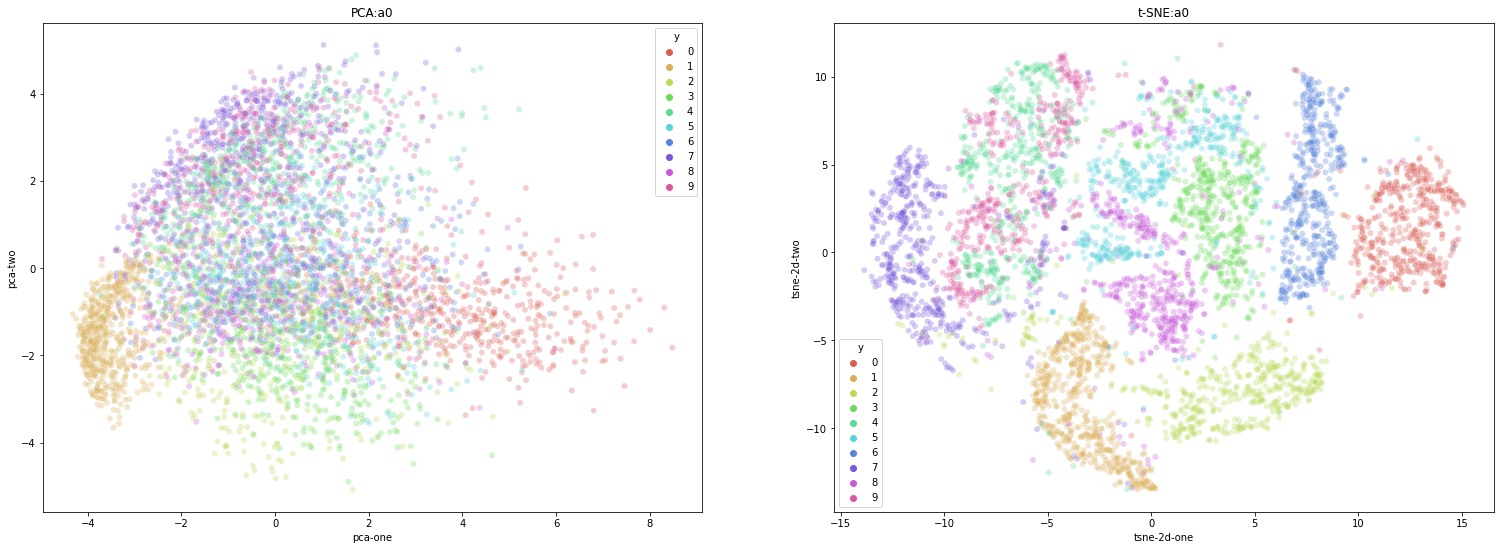

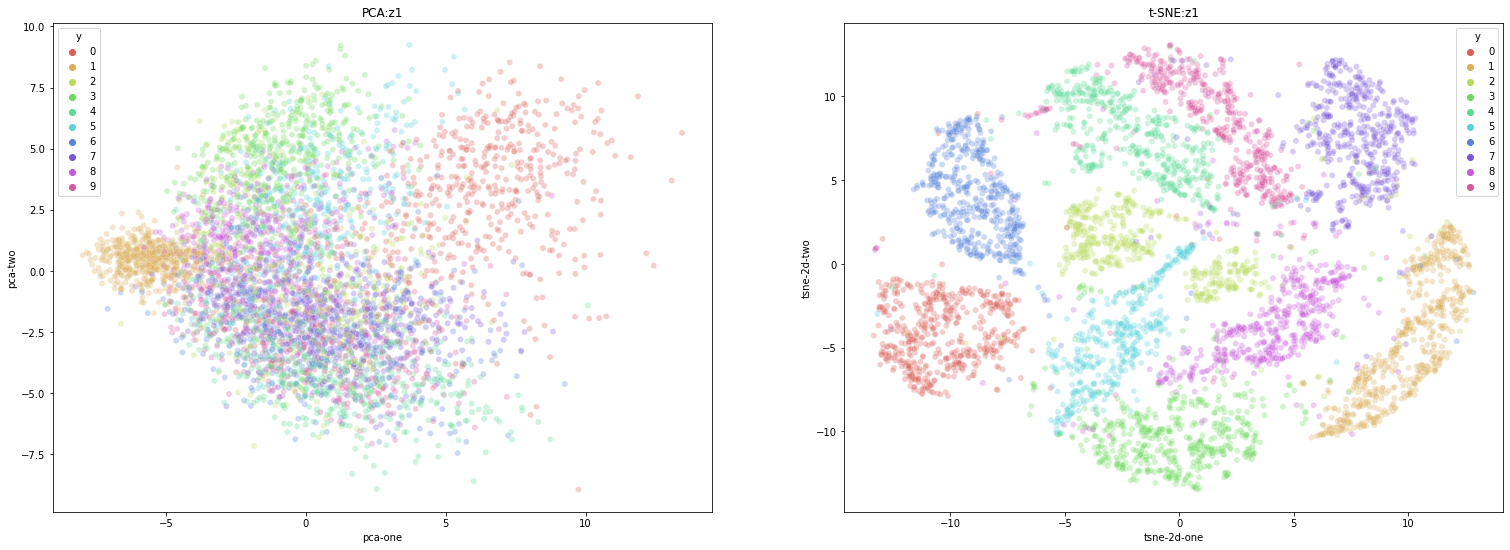

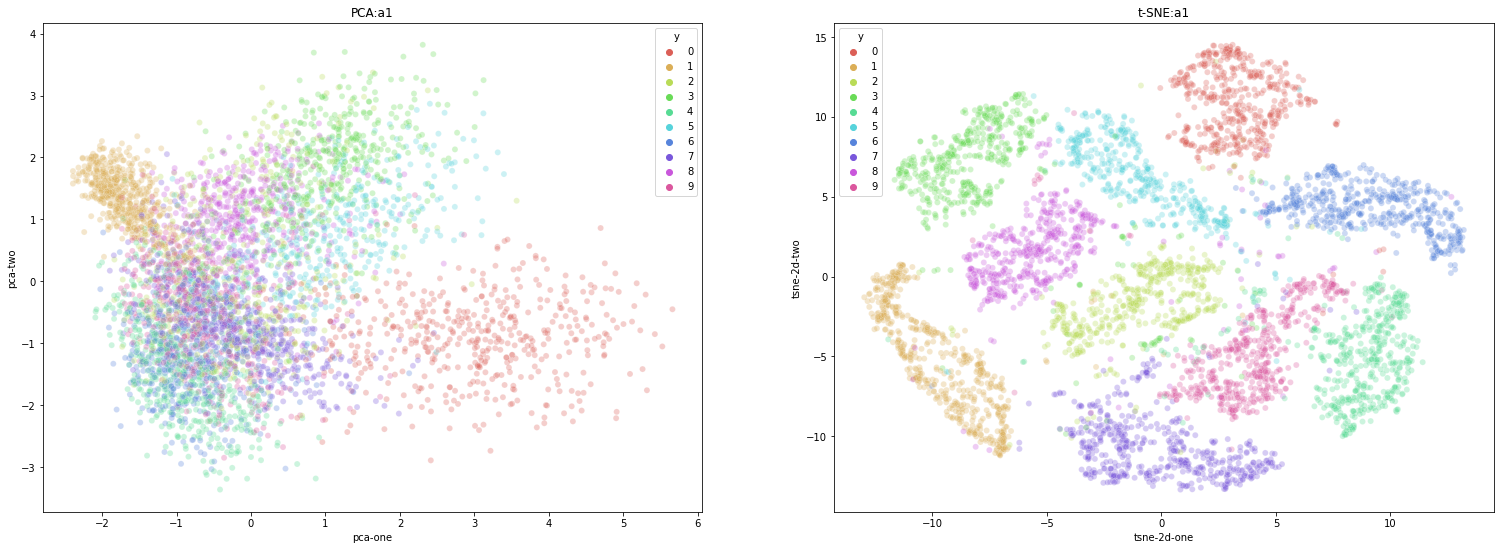

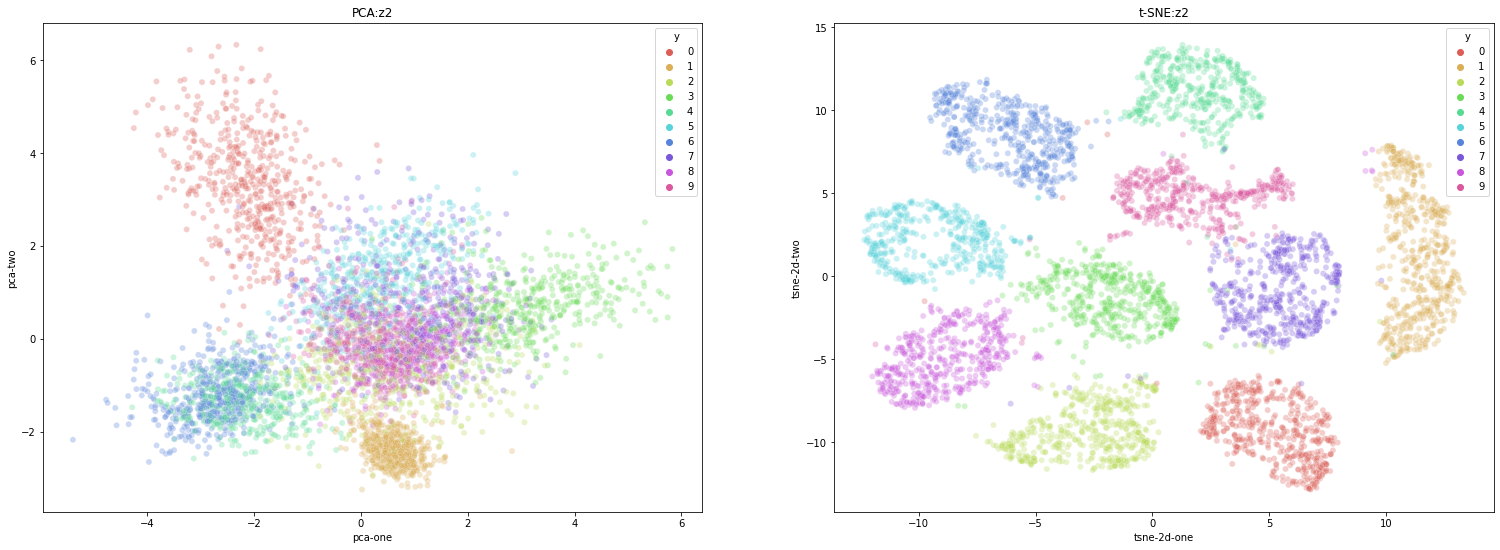

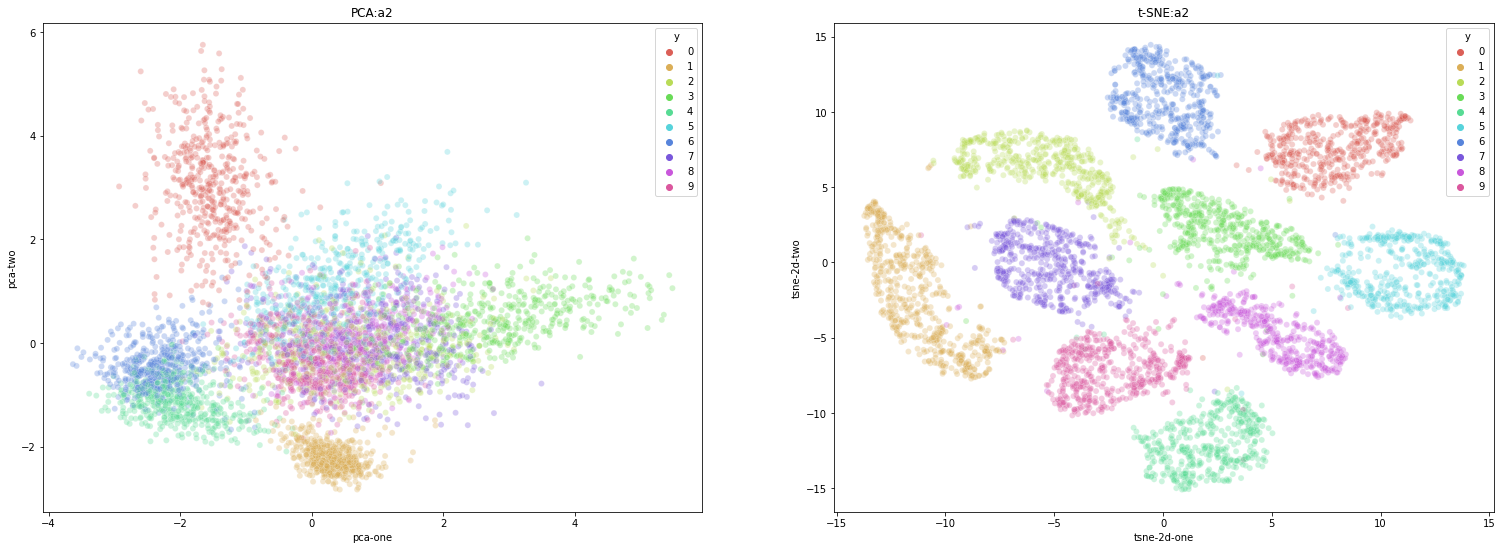

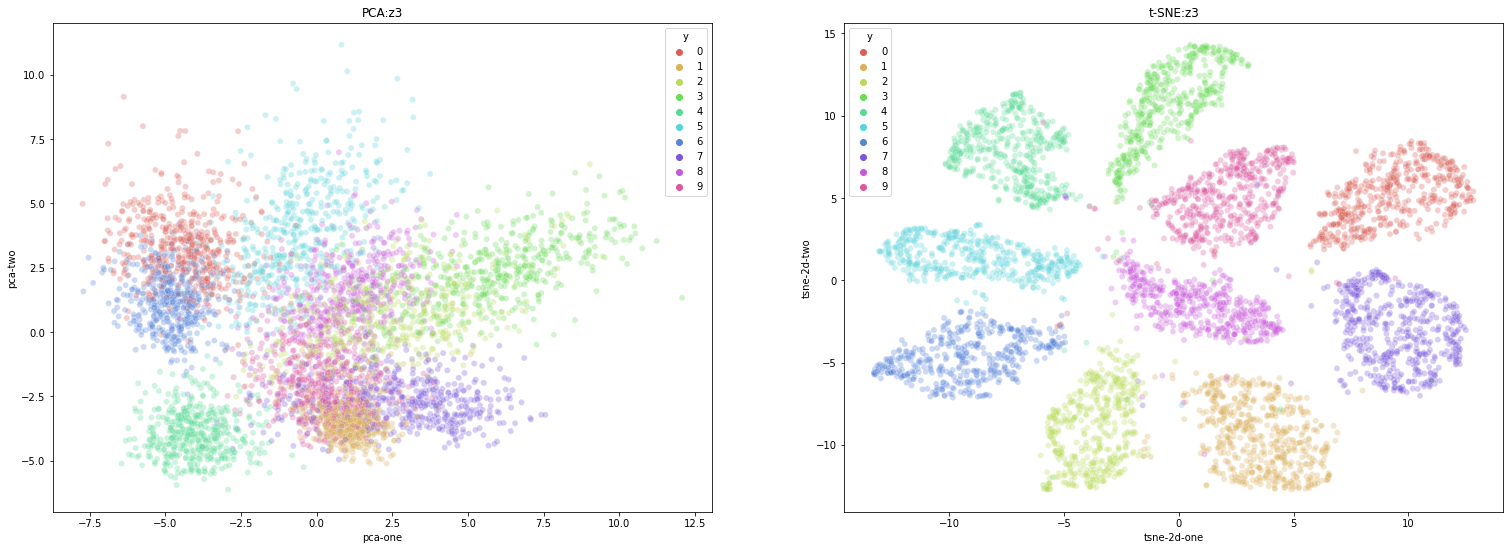

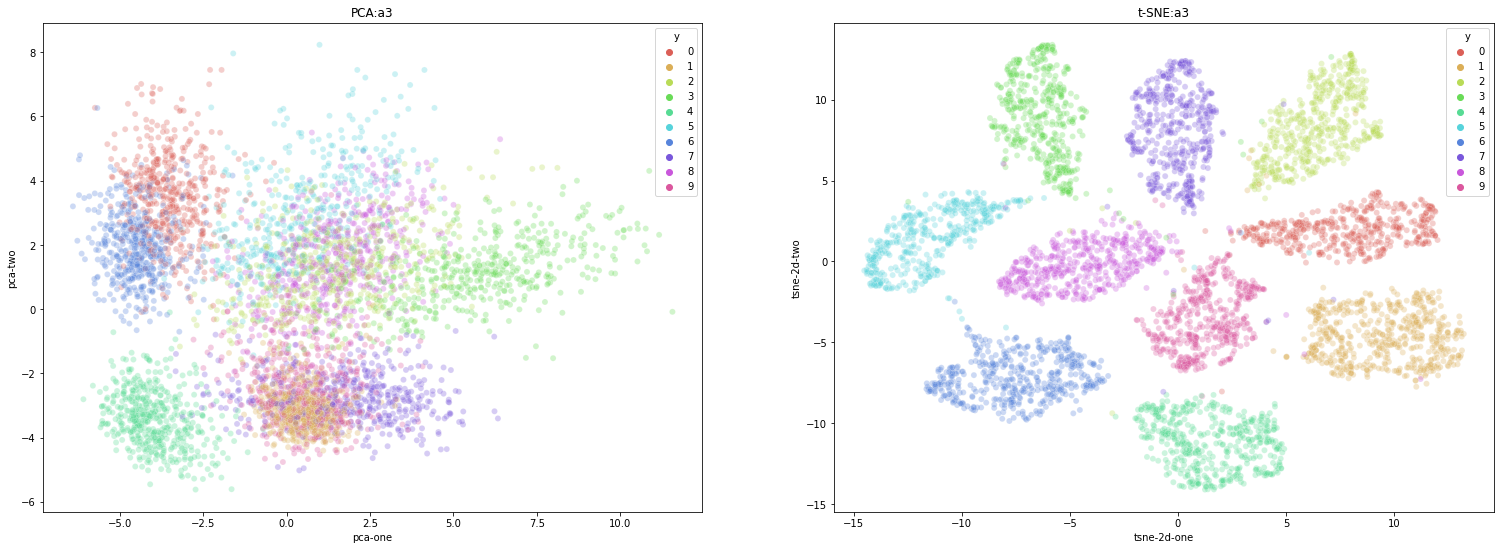

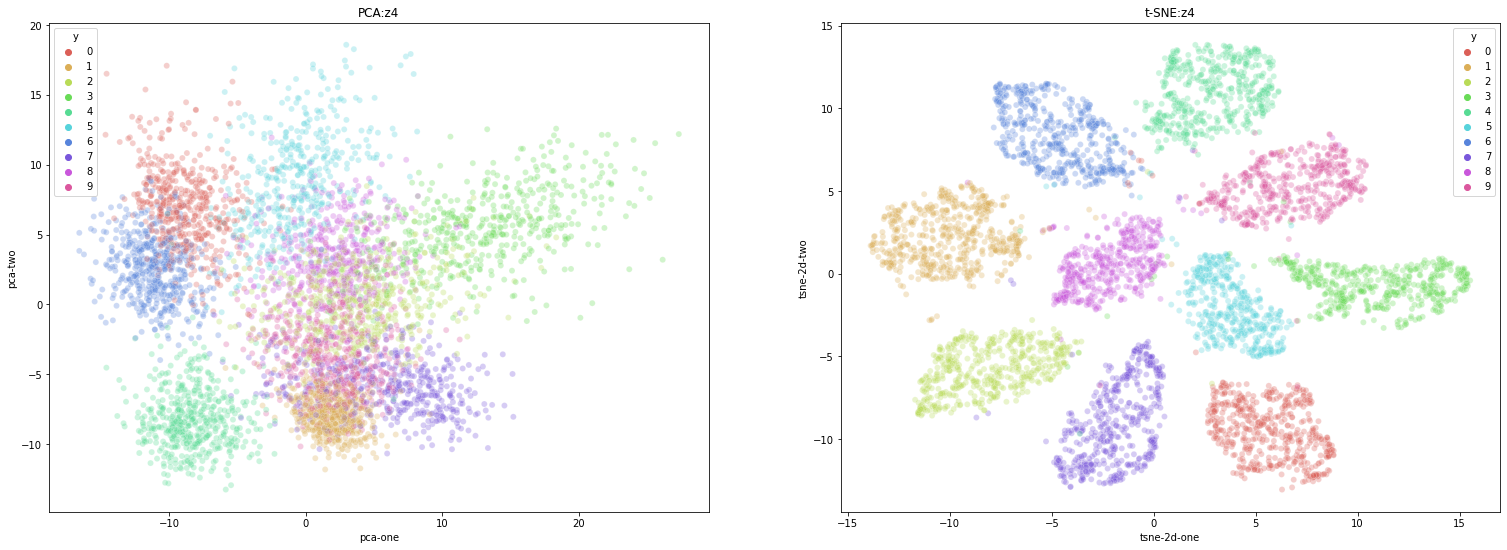

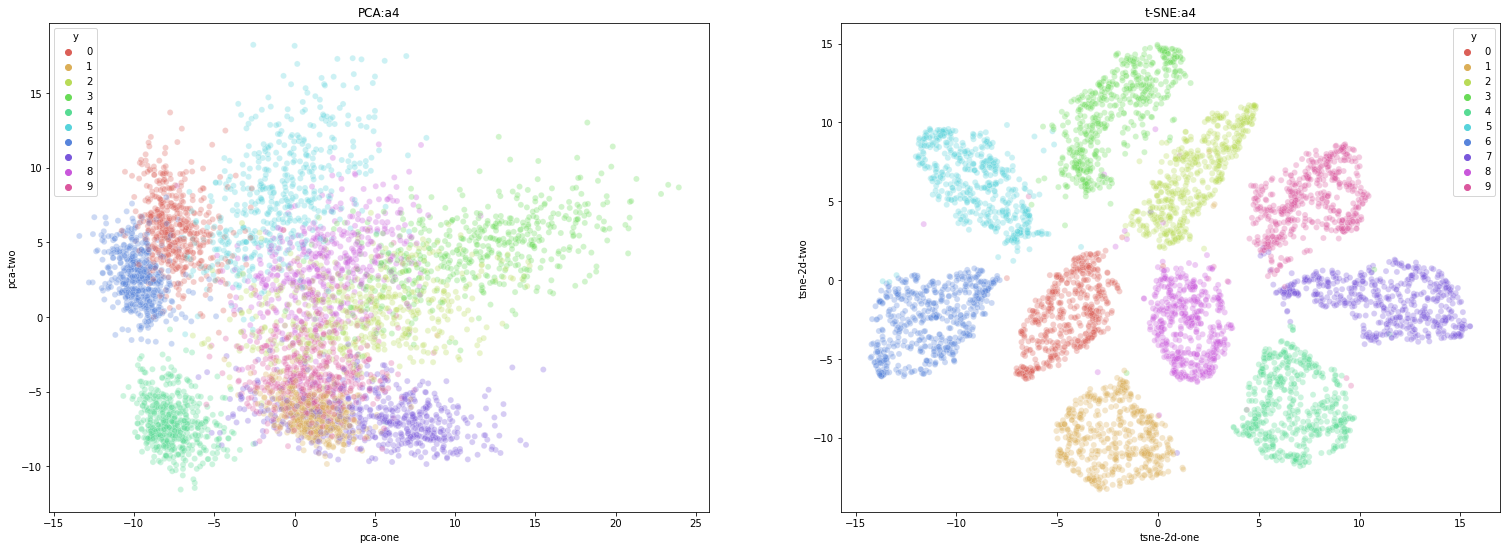

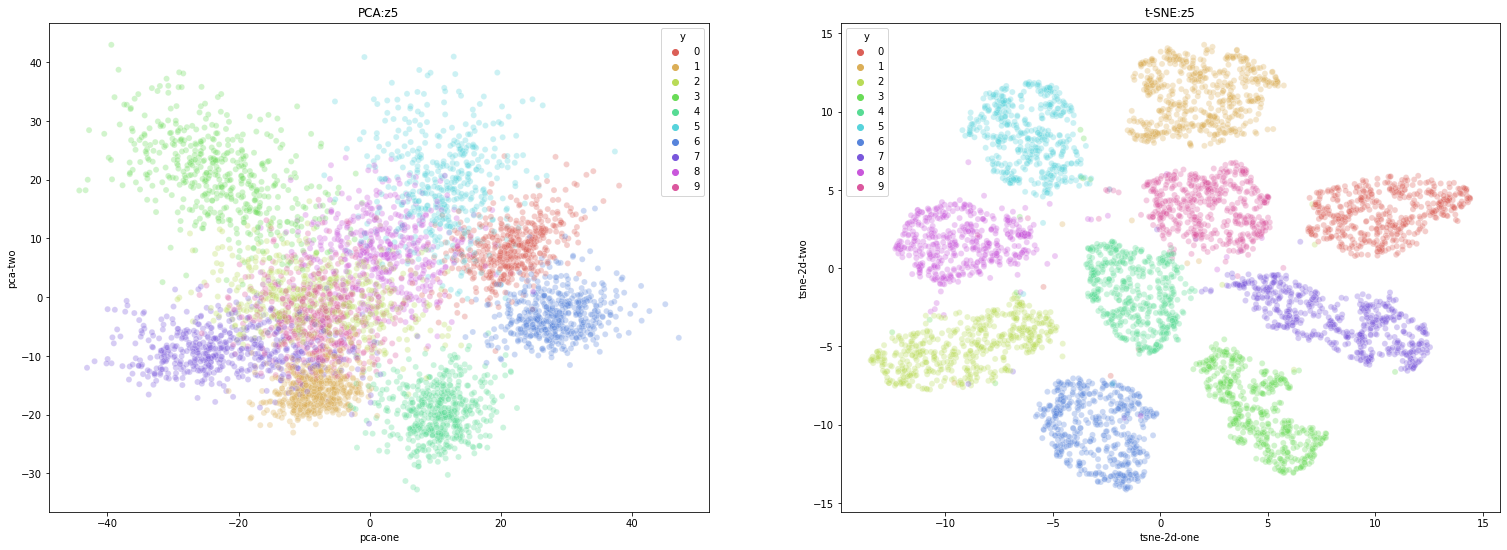

In [ ]:
for i in range(10):
    visual_1000.draw(i,n_list[i])